# Structural Damage Assesment for Windstorm Events

:::{important} ObjectivesAssessing the structural damage on buildings for a storm event.
- Gather windstorm footprints from Copernicus Data Store
- Obtain 50mx50m European land use raster data 
- Explore wind vulnerability curves for buildings
- Create new vulnerability curves to fit the land use data
- Match the data sets so they can be used for damage calculation
- Absolute and relative damage calculation!
:. 

## Risk assessment methodology.

This event-based windstorm risk workflow can be used to see damages of a storm by combining hazard, exposure and vulnerability. The workflow is a simplified version of the work by [Koks & Haer (2020)](https://doi.org/10.1038/s41598-020-63580-w). Here the hazard is a map with the maximum 3-second wind gust of a storm. Exposure is determined by a map in which assets are associated with maximum damage that can occur per square meter of the asset and a certain exposure class is given to the asset. Vulnerability is defined as a collection of damage curves where the 3 second wind gusts are matched to a percentage of the asset that is damad

 When overlaying the sets, all assets contain information on the type of asset class it is, the maximum damage that can occur at the asset, the vulnerability curve of the asset, and the windspeed at the asset location. With this information, one can do the damage calculation per asset. Step one is to inspect the vulnerability curve and how much of the asset is destroyed by the wind speed. This results in a fraction of the maximum damage value that occurs. Multiplying the maximum damage by the found damaged fraction results in the damage estimation of that asset. Doing this calculation for all asset locations in the region results in a map of the most affected locations.


### Hazard data
Using the Copernicus Climate Data store, [historical storm footprints](https://doi.org/10.24381/cds.9b4ea013) can be retrieved. Next to that, [synthetic storms footprints](https://doi.org/10.24381/cds.ce973f02) can be found that are physically realistic and thus plausible storms. These synthetic storms can be useful to create a larger overview of possible events that can affect the area in current-day situations. Both datasets give the footprints of the maximum 3-second gust per 72 hours per grid cell.  

### Exposure data
An example dataset that can be used in this workflow is the [LUISA Land Cover data](https://data.jrc.ec.europa.eu/dataset/51858b51-8f27-4006-bf82-53eba35a142c).  With this dataset, the exposed asset is a 50x50m grid cell. Each land cover type is given a certain asset class that can be associated with the vulnerability curves. 

Each land cover type is also associated with a maximum damage per square meter. A first estimation of the maximum damages are based on [JRC maximum damage estimates](https://dx.doi.org/10.2760/16510) per country.

### Vulnerability data  
Each asset class is associated with a vulnerability curve. The vulnerability data consists of six curves determined by [Feuerstein et al. (2011)](https://doi.org/10.1016/j.atmosres.2010.12.026). The asset classes are differentiated by the type of building that are mainly present in the asset. These estimate damage curves can be found in the supplied material. 


## Preparation work

### Load libraries

In this notebook, we will use the following Python libraries:

::::{grid} 2 3 4 4

:::{card}
:header: [os](https://docs.python.org/3/library/os.html)
To create directories and work with files
:::

:::{card}
:header: [zipfile](https://docs.python.org/3/library/zipfile.html#zipfile-objects)
To download and unzip the data
:::

:::{card}
:header: [xarray](https://docs.xarray.dev/en/stable/)
To process the data and prepare it for damage calculation
:::

:::{card}
:header: [rioxarray](https://corteva.github.io/rioxarray/stable/)
Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
:::

:::{card}
:header: [damagescanner](https://damagescanner.readthedocs.io/en/latest/#)
To calculate the damage maps
:::

:::{card}
:header: [matplotlib](https://matplotlib.org/)
To plot results
:::

:::{card}
:header: [numpy](https://numpy.org/) & [pandas](https://pandas.pydata.org/)
To work with and manipulate data
:::

:::{card}
:header: [cdsapi](https://cds.climate.copernicus.eu/api-how-to)
To download data from the Copernicus Data Store 
:::

:::{card}
:header: [contextily](https://contextily.readthedocs.io/en/latest/index.html#)
To plot maps with topographical context  
:::


In [1]:
import os
from zipfile import ZipFile
import rioxarray as rxr
import xarray as xr
from damagescanner.core import RasterScanner

import matplotlib.pyplot as plt

import cdsapi
import numpy as np
import pandas as pd

import contextily as ctx


### Create the directory structure
In order for this workflow to work, we need to set up the directory structure. The next cell will create the directory called 'storm_event_raster' in the same directory where this notebook is saved.

In [2]:
workflow_folder = 'storm_event_raster'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(f"{workflow_folder}/data")
    os.makedirs(f"{workflow_folder}/results")

data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')

### Download data

In this part, we will ensure we have all the files we need to complete this workflow.

Note that now we have a directory **storm_event_raster/data** where all the files should be placed.

#### Hazard data
First we need the information on the hazard we want to analyse. In this workflow we will start by downloading a storm in Latvia from the historical [wind storm data set](https://doi.org/10.24381/cds.9b4ea013). In the "Download data" tab select "widstorm footprints" and select one of the available dates.

Alternativel, you can also use the code below and download the data using the API provided by the Climate Data Store. Be sure to register an account and obtain the userid and the api key to place below

In [3]:
uid = 12345
apikey = 'xxxxxx'

c = cdsapi.Client(key=f"{uid}:{apikey}", url="https://cds.climate.copernicus.eu/api/v2")

zip_name = 'Klaus'

# check if cds api key, uid, and request in general is valid
try:
    c.retrieve(
        'sis-european-wind-storm-indicators',
        {
            'variable': 'all',
            'format': 'zip',
            'product': 'windstorm_footprints',
            'year': '2009',
            'month': '01',
            'day': '24',
        },
        f'{data_dir}/{zip_name}.zip'
        )
except:
    print('Error: Check your uid and apikey and if the retrieve request contains the correct values.')

2023-09-04 12:18:48,721 INFO Welcome to the CDS
2023-09-04 12:18:48,722 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/sis-european-wind-storm-indicators


Error: Check your uid and apikey and if the retrieve request contains the correct values.


### Exposure data
In this worflow we use the LUISA land cover data set. To log in you will need to create an account an download the raster data set from one of the available years. Click [here](http://data.europa.eu/89h/51858b51-8f27-4006-bf82-53eba35a142c) to go to data set page or download directly by clicking [here](http://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/LUISA/EUROPE/Basemaps/LandUse/2018/LATEST/LUISA_basemap_020321_50m.tif). Copy the 'LUISA_basemap_020321_50m.tif' file into the **storm_event_raster/data** folder.

### Vulnerability data
For this workflow initial information for the creation of maximum damages and damage curves are provided in `LUISA_damage_info_curves.xlsx` and `CURVES_feuerstein_koks.csv`. However, these are just estimates and need to be adjusted according to the regional context to provide valid damage estimations. Feel free to adjust manually.

## Explore the data
Now that we have downloaded and unpacked the needed data, we can have a look what is inside.  

:::{attention} ### Setting the region
First, we will set the region of interest through the use of a bounding box. This can be done by setting the corner coordinates of a self defined rectangle. See [https://boundingbox.klokantech.com](https://boundingbox.klokantech.com) to get the bounding box of your area of interest and put the coordinates in the next cell (select csv in the copy-paste field at the bottom of the website window).
:::

In [4]:
bbox =  [-8.811,42.6647,-7.1524,43.8009] #[1.3714,41.2488,3.3592,42.8507] # Catalunya region # [-8.811,42.6647,-7.1524,43.8009] Galicia [lon_min, lat_min, lon_max, lat_max]


:::{tip} Explore the file content
Fell free to explore the content and structure of the datasets.  
Note the coordinates, dimensions and attributes!
:::

:::{hint} Find the information about spatial references, statistics👆 (click)
:class: dropdown
👋 Click on **spatial_ref** 📄 _show/hide attributes_ to see the spatial information  
👋 Look at _STATISTICS_ attributes to find minimum, maximum and other statistics

:::

### Hazard data

The dowloaded storm footprints can be visualised to get an overview of what it in the dataset. First, we need to open the storm footprint from the downloaded zipfile. Then we change the dimension from latitude and longitude to y and x so we can work with and manipulate the data later. Then, we need to set the CRS of the dataset since that has not be predefined by the Copernicus Climate Data Store. Before plotting we need to select the right variable to plot ('FX') and specify the band of interst, in this case there is only one so that is easy (z=1)

Text(0.5, 1.0, 'Windstorm across Europe')

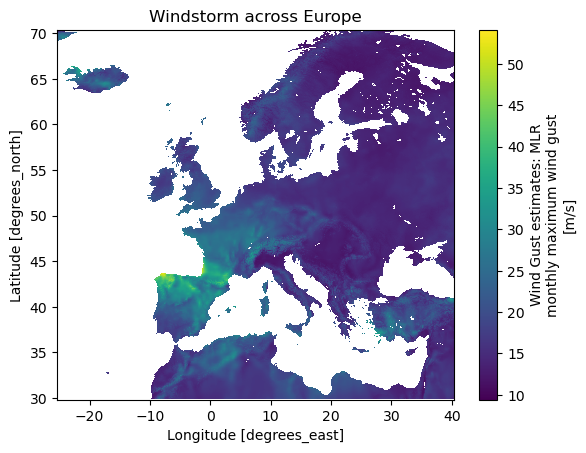

In [5]:
with ZipFile(f"{data_dir}/{zip_name}.zip") as zf:
    
    # Let's get the filename first
    file = zf.namelist()[0]

    # And now we can open and select the file within Python
    with zf.open(file) as f:
        windstorm_europe = xr.open_dataset(f)

windstorm_europe = windstorm_europe.rename({'Latitude': 'y','Longitude': 'x'})
windstorm_europe = windstorm_europe.rio.set_spatial_dims(x_dim="x",y_dim="y", inplace=True)

windstorm_europe.rio.write_crs(4326, inplace=True)

windstorm_europe = windstorm_europe['FX']['z'==1]

#plot
windstorm_europe.plot()
plt.title('Windstorm across Europe')

In the plot above you can see the high windspeeds of the storm light up in yellow across Europe

### Exposure data

Next we analyse the exposure data. There are datasets to analyse. First, the downloaded landcover data and then the maximum damage per landcover class.

#### Land cover data

Using rioxarray, the lancover data is opened and the correct band is selected. In this case the band of interest is 1 (also the only band). Also for this dataset the crs needs to be written. From there we want to visualise the land cover map, however, since the land cover data has a detailed resolution (100mx100m) it takes a long time to plot all of Europe. That is why we clip the land use to the region of our bounding box before plotting. To match the colours on the LUISA Land Cover data portal we define a set of colours to plot the data with.

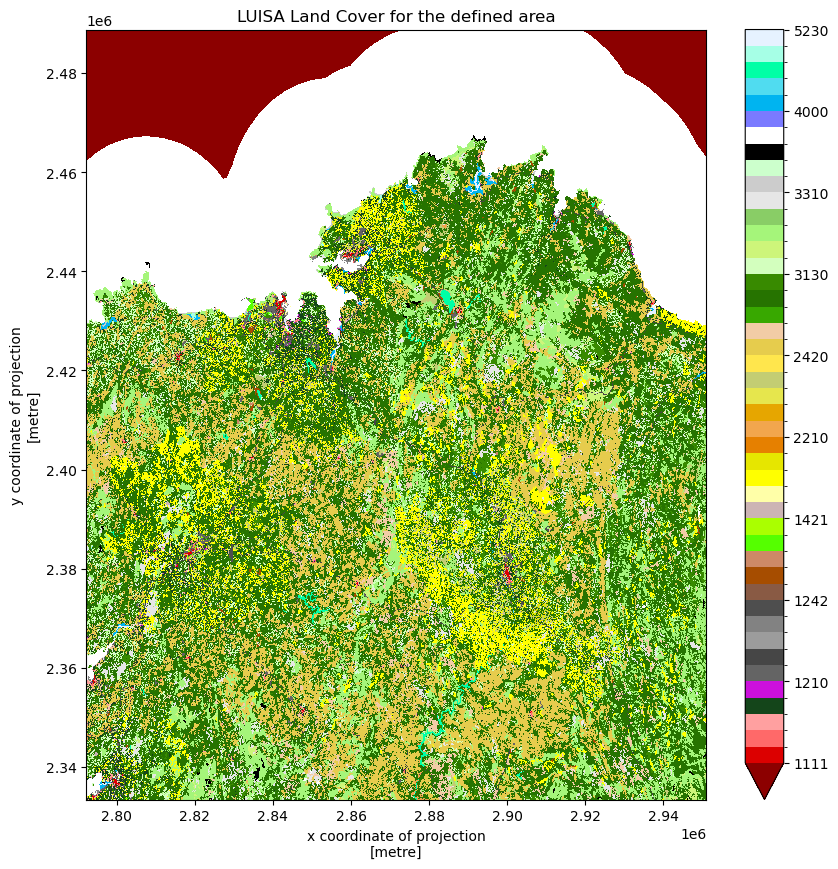

In [6]:
filename_land_use = f'{data_dir}/LUISA_basemap_020321_50m.tif'
land_use = rxr.open_rasterio(filename_land_use)
land_use = land_use['band'==1]
land_use = land_use.drop(['band'])
land_use.rio.write_crs(3035, inplace=True)

land_use_test_plot = land_use.rio.clip_box(*bbox,
                                        crs="EPSG:4326")

LUISA_values = [1111,1121, 1122, 1123, 1130,
                1210, 1221, 1222, 1230, 1241,
                1242, 1310, 1320, 1330, 1410,
                1421, 1422, 2110, 2120, 2130,
                2210, 2220, 2230, 2310, 2410,
                2420, 2430, 2440, 3110, 3120,
                3130, 3210, 3220, 3230, 3240,
                3310, 3320, 3330, 3340, 3350,
                4000, 5110, 5120, 5210, 5220,
                5230]

LUISA_colors = ["#8c0000", "#dc0000", "#ff6969", "#ffa0a0", "#14451a",
                "#cc10dc", "#646464", "#464646", "#9c9c9c", "#828282",
                "#4e4e4e", "#895a44", "#a64d00", "#cd8966", "#55ff00",
                "#aaff00", "#ccb4b4", "#ffffa8", "#ffff00", "#e6e600",
                "#e68000", "#f2a64d", "#e6a600", "#e6e64d", "#c3cd73",
                "#ffe64d", "#e6cc4d", "#f2cca6", "#38a800", "#267300",
                "#388a00", "#d3ffbe", "#cdf57a", "#a5f57a", "#89cd66",
                "#e6e6e6", "#cccccc", "#ccffcc", "#000000", "#ffffff",
                "#7a7aff", "#00b4f0", "#50dcf0", "#00ffa6", "#a6ffe6",
                "#e6f2ff"]


# plot the land use
land_use_test_plot.plot(levels=LUISA_values, colors=LUISA_colors, figsize=(10,10))
plt.title('LUISA Land Cover for the defined area')

# we delete the map variable to save computing resources for later 
del land_use_test_plot

#### Maximum damage per land cover class

Next, we extract the maximum structural damage that can occur per land use class  [€/m²] from the larger `LUISA_damage_info_curves.xlsx` sheet and save it to something we can use later. We only show the first 10 values, just to get an idea of what is in there. We see that there is quite a bit of variation in the type of landuse and the value that it has.

In [7]:
LUISA_info_damage_curve = pd.read_excel('LUISA_damage_info_curves.xlsx', index_col=0)
# get the maxdamage for reconstruction
maxdam = pd.DataFrame(LUISA_info_damage_curve['structural €/m²'])
maxdam.to_csv(f'{data_dir}/maxdam_luisa.csv')
maxdam.head(10)

,structural €/m²
Land use code,
1111,343.011305
1121,243.823177
1122,140.013142
1123,36.799571
1130,0.000000
1210,180.105953
1221,16.166945
1222,226.337232
1230,97.001671


### Vulnerability

Finaly, we inspect the vulnerability curves that we will use in the analysis. In the index we see that there is the windspeed associated with a construction class and a fraction of the buidling of a specific class that is destroyed at that wind speed. The end of the table is shown to represent fraction of the buidling that is damaged at high wind speeds. 

In [8]:
curves_feuerstein = pd.read_csv(f'CURVES_feuerstein_koks.csv', index_col=0)
curves_feuerstein.tail()

,weakest outbuilding,outbuilding strong,outbuilding,weak brick structure,strong brick structure,concrete buidling
wind speed,,,,,,
136,100.0,100.0,100.0,100.0,99.50,85.5
137,100.0,100.0,100.0,100.0,99.70,86.1
138,100.0,100.0,100.0,100.0,99.90,86.5
139,100.0,100.0,100.0,100.0,99.99,86.8
140,100.0,100.0,100.0,100.0,100.00,87.0


Plotting the curves makes the damage functions more insight full. Steep curves indicate a quick change in damage with only a small change in wind speed. Flat curves indicate a small change in damage with a large change in wind speed and are therefore more resillient to high windspeeds.

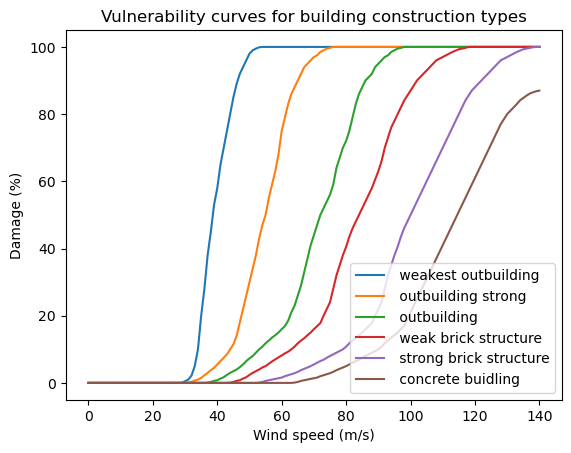

In [9]:
curves_feuerstein.plot()
plt.title('Vulnerability curves for building construction types')
plt.ylabel('Damage (%)')
plt.xlabel('Wind speed (m/s)')

# only show legend for the first 10 entries
plt.legend(curves_feuerstein.columns[:10], loc='lower right')

## Process the data

In this section we will first process the data before we do our damage calculations. This is needed since the windspeed map and land cover map have different resolutions and projections meaning they do not match when we overlay them directly. Also the vulnerability curves need to be adjusted to fit with the types of buildings in the land use class.

## Clipping to the region

Before we calculate for the whole of Europe (meaning a lot of calculation time) we snip the datasets to our region of interest.

### Hazard

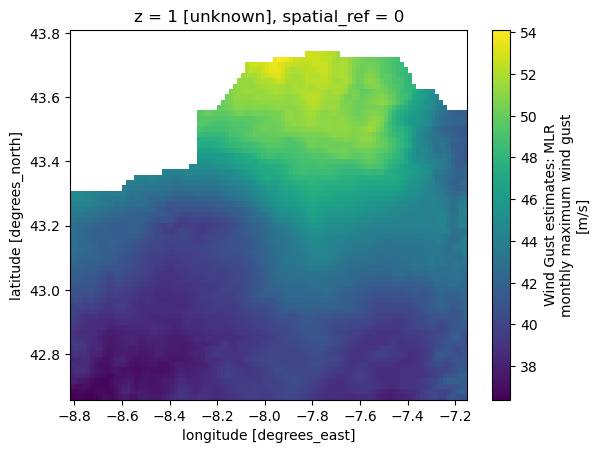

In [10]:
windstorm_region = windstorm_europe.rio.clip_box(*bbox, 
                                                 crs="EPSG:4326")


windstorm_region.plot()

# we delete the map variable to save computing resources for later 
del windstorm_europe


### Exposure

Since the land use data is also for the whole of Europe we clip our region to our defined bounding box too. However, we keep the land use file in its original CRS

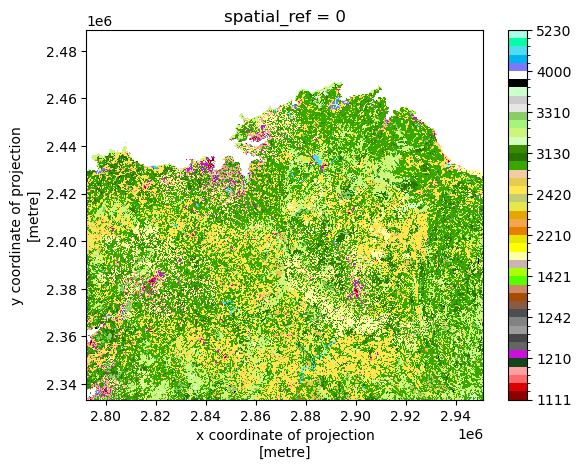

In [11]:

# clip land use to the same extent as the windstorm
land_use_region = land_use.rio.clip_box(*bbox,
                                        crs="EPSG:4326")

# Only keep values higher than 0 (no data)
land_use_region = land_use_region.where(land_use_region > 0)
land_use_region.plot(levels=LUISA_values, colors=LUISA_colors)

# we delete the map variable to save computing resources for later 
del land_use

Now that we have our region of interst for the land cover. It is also interesting to see the damage potential in the region due to high wind speeds. We see that most valuable assests are located in the cities.

Text(0.5, 1.0, 'Damage potential of structures in the region based on land use and maxdamages')

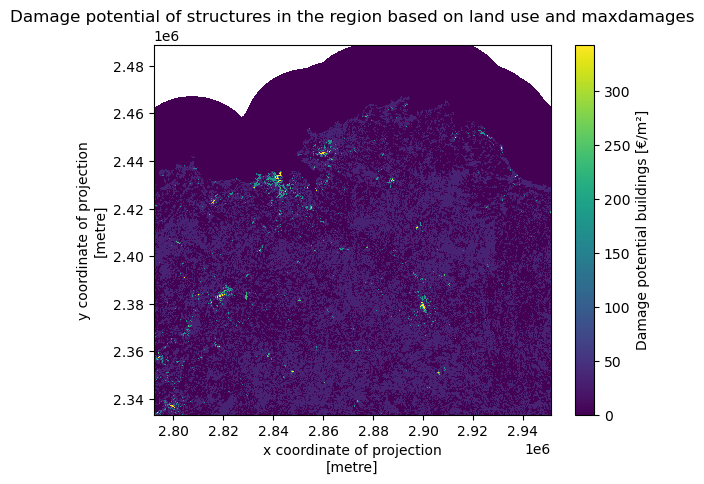

In [12]:
# assign each land use class a maxdamage value and plot this on the map
maxdam_map = land_use_region
for class_i in maxdam.index:
    maxdam_map = maxdam_map.where(land_use_region != class_i, maxdam['structural €/m²'][class_i])
maxdam_map.plot(cbar_kwargs={'label': "Damage potential buildings [€/m²]"})
plt.title('Damage potential of structures in the region based on land use and maxdamages')

## Vulenerability
Here we will adjust the damage curves of Feurstein et al. (2011) to fit our LUISA land use map. From the Luisa info excel sheet we can retrieve a ratio of the type of buildings per land use class. If a land use class contains a lot of one certain construction type the vulnerbality curve will be close of the one represented by Feurstein et al. (2011). Otherwise it will be a curve that is a mix of the building construction types according to the ratio of structures in the land use. We see a large variation in vulnerability curves. Also some curves that are flat at 0. These represent that they are not affected by wind such as water bodies.   

In [13]:
# create a new dataframe for damage_curves_luisa where wind and landuse classes are used
damage_curves_luisa = curves_feuerstein.copy()
# drop all columns
damage_curves_luisa.drop(damage_curves_luisa.columns, axis=1, inplace=True)

building_types = ['weakest outbuilding', 'outbuilding',	'strong outbuilding', 'weak brick structure',	'strong brick structure', 'concrete buidling']

# for each land use class in maxdamage create a new damage curve
for landuse in maxdam.index:
    # find the ratio of building types in the class
    ratio = LUISA_info_damage_curve.loc[landuse, building_types].values

    # new curve
    damage_curves_luisa[landuse] =  ratio[0] * curves_feuerstein.iloc[:,0] + \
                                    ratio[1] * curves_feuerstein.iloc[:,1] + \
                                    ratio[2] * curves_feuerstein.iloc[:,2] + \
                                    ratio[3] * curves_feuerstein.iloc[:,3] + \
                                    ratio[4] * curves_feuerstein.iloc[:,4] + \
                                    ratio[5] * curves_feuerstein.iloc[:,5]
    
damage_curves_luisa.to_csv(f'{data_dir}/damage_curves_luisa.csv')

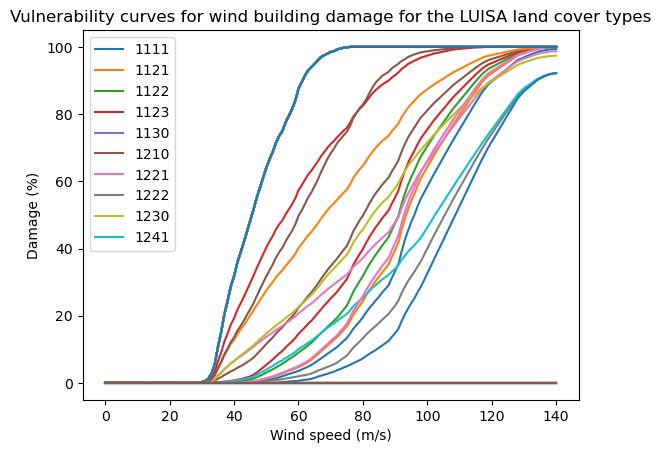

In [14]:
damage_curves_luisa.plot()
plt.title('Vulnerability curves for wind building damage for the LUISA land cover types')
plt.ylabel('Damage (%)')
plt.xlabel('Wind speed (m/s)')

# only show legend for the first 10 entries
plt.legend(damage_curves_luisa.columns[0:10], loc='upper left')

### Matching the two layers

Now that the two datasets are in the same region, we can increase the resoltution of the windmap and reproject the windmap to match that of the land cover map. When increasing the resolution we need to do something with the added datapoints in our map. We can either fill these new datapoints in with whatever valaue is nearest in the orignal data set or we can interpolate the data. Choose something that makes sense. For wind data it is more logical to interpolate since abrupt changes along an arbitrary line of pixels is unlikely. However, for land use data it might make sense to choose the nearest datapoint. Otherwise the interpolation method will create new land use classes, which will be void of meaning. For example, on the edge between land use class 10 and 11 it will create 10.5 or between class 1 and 10 it will set pixels to 5 without the pixel actually being class 5.

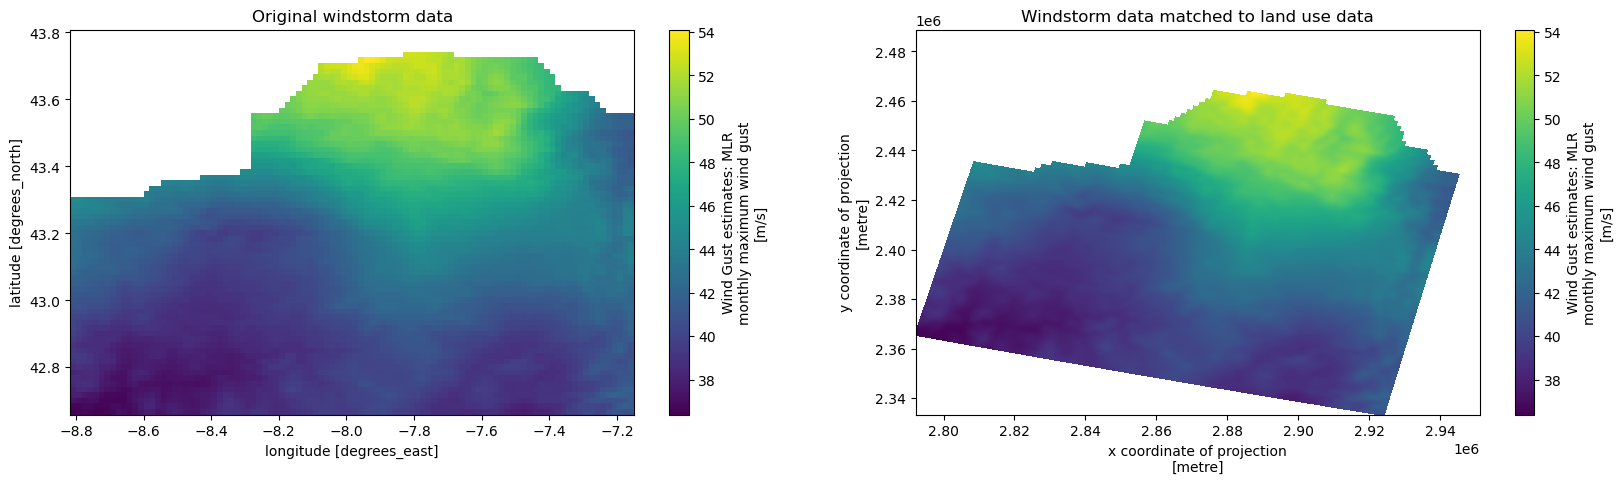

In [15]:
from rasterio.enums import Resampling

windstorm_region_matched = windstorm_region.rio.reproject_match(land_use_region, resampling = Resampling.cubic) # can also be .nearest or


windstorm_region_matched = windstorm_region_matched.assign_coords({
    "x": land_use_region.x,
    "y": land_use_region.y,
})


# plot windstorm_region and windstorm_region_matched next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

windstorm_region.plot(ax=ax1)
ax1.set_title("Original windstorm data")

windstorm_region_matched.plot(ax=ax2)
ax2.set_title("Windstorm data matched to land use data")

# we delete the map variable to save computing resources for later 
del windstorm_region


We find two things. Firstly, the map is skewed due to our reprojection and secondly the map is smoother than the original dataset due to our Resampling method.

Now we can overlay the two images to get a quick look at where high windspeeds are and where certain land cover classes are. We see that there is some mismathc between the maps due to our reprojection. When the damage estimates are calculated only values are calculated for the locations where both maps overlap

Text(0.5, 1.0, 'Windstorm and land use 2018')

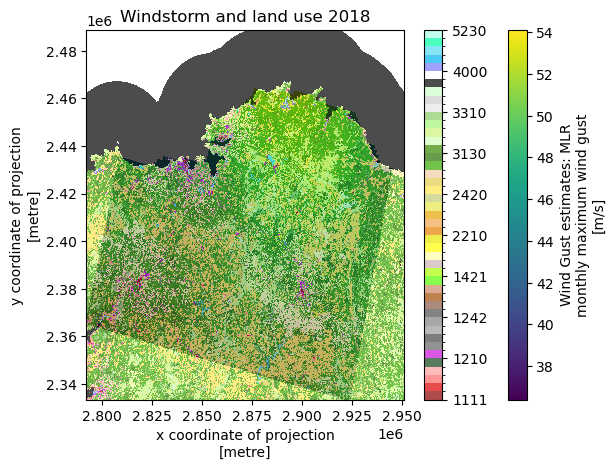

In [16]:
# plot
fig, ax = plt.subplots()
windstorm_region_matched.plot(ax=ax, cmap='viridis', alpha=1)
land_use_region.plot(ax=ax, levels=LUISA_values, colors=LUISA_colors, alpha=0.7)
ax.set_title('Windstorm and land use 2018')

Note! Because the used DamageScanner package uses the resolution of the maps to calculate the area in m² it is important that both maps are in a CRS that uses meters instead of degrees. 

In [17]:
# set the correct order of the coordinates in the data set
windstorm_region_matched.transpose('y', 'x')
land_use_region=land_use_region.transpose('y', 'x')


Now we save the raster maps of the windstorm and land use to .tif files so these can be used in the damage calculation

In [18]:
windstorm_region_matched.rio.to_raster(f'{data_dir}/windstorm_region_matched.tif')
land_use_region.rio.to_raster(f'{data_dir}/land_use_region.tif')

## Calculate structural damage

Now that we have everything ready, we can do the damage calculation using the RasterScanner function from the DamageScanner python package. Making the 

In [19]:
# code for the calculation

wind_map = os.path.join(data_dir,'windstorm_region_matched.tif')
landuse_map = os.path.join(data_dir,'land_use_region.tif')

curve_path = os.path.join(f'{data_dir}/damage_curves_luisa.csv')
maxdam_path = os.path.join(f'{data_dir}/maxdam_luisa.csv')

damage_catagory, _, _, _ = RasterScanner(landuse_file = landuse_map,
                                        hazard_file = wind_map,
                                        curve_path = curve_path,
                                        maxdam_path = maxdam_path,
                                        scenario_name= f'{results_dir}/Windstorm_Klaus_Catalunya',
                                        lu_crs=land_use_region.rio.crs,
                                        haz_crs=windstorm_region_matched.rio.crs,
                                        in_millions = False,                   
                                        dtype = np.int64, # if set to int32 it gives an error
                                        save=True)


## Plot the results

From the results we can obtain the total damages in the area per land cover class. We first check the summed damage for each land use class. Land cover classes can obtain high damages because they are either valuable per m² or a lot of area in the region is of a certain land cover. For example, large but not as valuable land can still have a higher damage total than small but very valuable land.  

In [20]:
damage_catagory.T

landuse,1111,1121,1122,1123,1130,1210,1221,1222,1230,1241,...,3320,3330,3340,3350,4000,5110,5120,5210,5220,5230
damages,659.579095,1127.979486,3231.020165,27107.413124,0.0,104466.834403,12401.680568,0.0,6178.64627,628.732501,...,1838.943362,9247.204841,54.865202,0.0,43182.59105,0.0,0.0,0.0,0.0,0.0


In [21]:
# we calculate the total damage in the region of the event in millions of euros 
print(f"Total damages in the region [mln. €]: { damage_catagory.sum().values[0] / 10 ** 6}")


Total damages in the region [mln. €]: 8.531338295441001


Now we will plot the damages on a map to gain more insight where the storm caused most damage. First we plot pure economic value that is affected and then we asses which location are relatively hit the hardest by a wind storm by representing the manifested structural damage versus the maximum structural damage.

In [22]:
# import the saved damagemap into python 
damage_map = rxr.open_rasterio(f'{results_dir}/Windstorm_Klaus_Catalunya_damagemap.tif')

In [23]:
# Currently the damages are represented in total damage of a grid cell so we change it to represent damage per m2
damage_map_adjusted = damage_map / (abs(damage_map.rio.resolution()[0] * damage_map.rio.resolution()[1]))

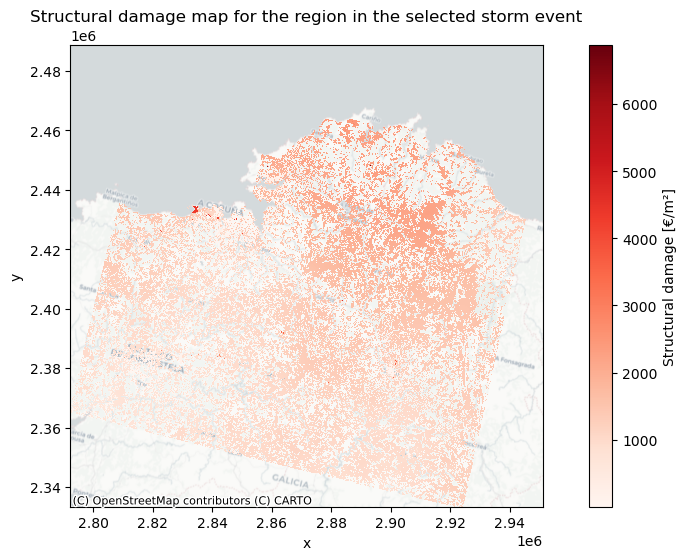

In [24]:
# create figure
fig, ax = plt.subplots(figsize=(12, 6))

damage_map_adjusted = damage_map_adjusted.where(damage_map_adjusted > 0)

damage_map_adjusted.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': "Structural damage [€/m²]"})
plt.title('Structural damage map for the region in the selected storm event')

# add basemap from openstreetmap
ctx.add_basemap(ax, crs=damage_map_adjusted.rio.crs.to_string(), alpha=1, source=ctx.providers.CartoDB.Positron)


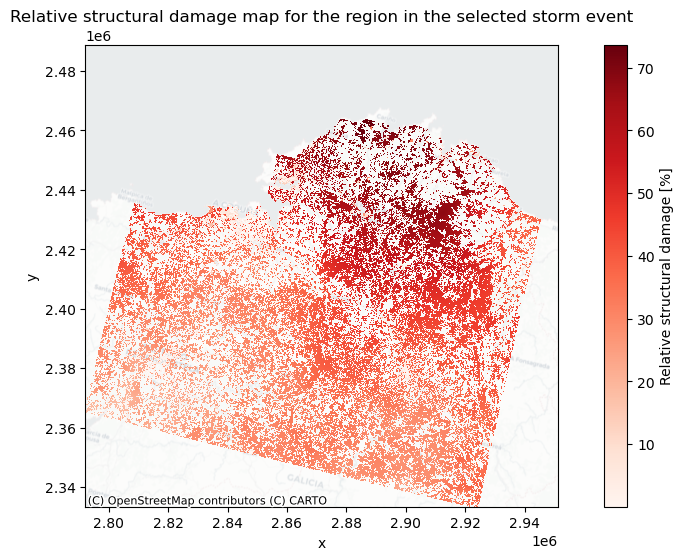

In [25]:
# plot the relative damage for each land use class
fig, ax = plt.subplots(figsize=(12, 6))
# set figure size

relative_damage = damage_map_adjusted / maxdam_map

# filter out assests that do not have a damage potential
relative_damage = relative_damage.where(relative_damage > 0)

relative_damage.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': "Relative structural damage [%]"})

plt.title('Relative structural damage map for the region in the selected storm event')

# add basemap from openstreetmap
ctx.add_basemap(ax, crs=relative_damage.rio.crs.to_string(), alpha=0.5, source=ctx.providers.CartoDB.Positron)


## Conclusions

In this risk assessment workflow we learned how to match event and land cover maps so they can be put into the damagescanner function. We then visualised the damage estimation for a storm using pure economic damage and then using relative structural damage.  

## Contributors

**Authors**: 
- Ted Buskop (Deltares & Vrije Universiteit Amsterdam, IVM)

**References**: 

- Koks, E.E., Haer., T. A high-resolution wind damage model for Europe. Sci Rep 10, 6866 (2020). https://doi.org/10.1038/s41598-020-63580-w

- Copernicus Climate Change Service, Climate Data Store, (2022): Winter windstorm indicators for Europe from 1979 to 2021 derived from reanalysis. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.9b4ea013 (Accessed on DD-MMM-YYYY)

- Copernicus Climate Change Service, Climate Data Store, (2022): Synthetic windstorm events for Europe from 1986 to 2011. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.ce973f02 (Accessed on DD-MMM-YYYY)

- Feuerstein, B., Groenemeijer, P., Dirksen, E., Hubrig, M., Holzer, A. M., & Dotzek, N. (2011). Towards an improved wind speed scale and damage description adapted for Central Europe. Atmospheric Research, 100(4), 547-564. https://doi.org/10.1016/j.atmosres.2010.12.026

- Pigaiani, C. and Batista E Silva, F., The LUISA Base Map 2018, EUR 30663 EN, Publications Office of the European Union, Luxembourg, 2021, ISBN 978-92-76-34207-6,  https://doi.org/10.2760/503006, JRC124621.

